# Arbolado IA
-------

### Paquetes
---

In [2]:
# General
import ast
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

# sklearn & XGB
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

import xgboost as xgb
from xgboost import XGBRegressor 
from xgboost import XGBClassifier



# imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit

### Carga de datos
----

In [3]:
# Carga de datos
df1 = pd.read_csv('./data-arbolado-junior.csv')
df1 = df1.drop(columns=['id'])
df2 = pd.read_csv('./data-arbolado-crisol.csv')
df3 = pd.read_csv('./data-arbolado-gralpaz.csv')

df = pd.concat([df1, df2, df3])

In [4]:
print("El tamaño del DataFrame es: \n")
print(f'Shape: {df.shape}')

df.head()

El tamaño del DataFrame es: 

Shape: (7970, 28)


,fecha,latitud,longitud,direccion,barrioNombre,altura,fuste,faseVital,estadoFitosanitario,inclinacion,...,intervenciones,distForestalAdecuada,interf,cazuela,levantamientoVereda,observaciones,especieNombre,lugarRelevamientoNombre,tipoLugarNombre,Observaciones
0,7/2/2018,-31.418802,-64.170274,906,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Inadecuada,Leve,NaN,Palmera Pindó,Americo Vespucio 900-1000,Calle,NaN
1,7/2/2018,-31.418807,-64.170212,916,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Regular,Leve,...,Mantenimiento,True,True,Adecuada,Leve,NaN,Siempre Verde,Americo Vespucio 900-1000,Calle,NaN
2,7/2/2018,-31.418807,-64.170161,924,Juniors,Menor a 4m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Franja Verde,No,NaN,Crespón,Americo Vespucio 900-1000,Calle,NaN
3,7/2/2018,-31.418832,-64.170114,930,Juniors,Entre 7m. y 10m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,Leve,...,Mantenimiento,True,False,Franja Verde,No,NaN,Guaran Amarillo,Americo Vespucio 900-1000,Calle,NaN
4,7/2/2018,-31.418868,-64.169999,932,Juniors,Menor a 4m.,"Menor a 0,10m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Franja Verde,No,NaN,Ficus Benjamina,Americo Vespucio 900-1000,Calle,NaN


## Ingeniería de Datos
----

In [5]:
cols_to_drop = [
    "fecha", "latitud", "longitud", "direccion", 
    "barrioNombre", "observaciones", "lugarRelevamientoNombre", 
    "tipoLugarNombre", "Observaciones"
]
df = df.drop(columns=cols_to_drop)

In [6]:
print(df.columns)

Index(['altura', 'fuste', 'faseVital', 'estadoFitosanitario', 'inclinacion',
       'ahuecamiento', 'problemaDesrames', 'problemaDescalzado',
       'problemaFustePartido', 'problemaObjetoExtranio', 'problemaGrieta',
       'problemaDesequilibrioCopa', 'manejoInadecuado', 'intervenciones',
       'distForestalAdecuada', 'interf', 'cazuela', 'levantamientoVereda',
       'especieNombre'],
      dtype='object')


### DataFrame discreto
---

In [7]:
filas_con_nan = df.isna().any(axis=1)

# Cantidad de filas con al menos un dato vacío
print(f"Filas con al menos un NaN: {filas_con_nan.sum()}")

# Filtrar esas filas
df = df[~df.isna().any(axis=1)].copy()

Filas con al menos un NaN: 978


In [8]:
label_maps = {}

le = LabelEncoder()

for col in df.columns:
    # Ignora columnas completamente vacías
    if df[col].dropna().empty:
        continue

    first_val = df[col].dropna().iloc[0]

    # Columnas booleanas (True/False)
    if isinstance(first_val, bool):
        df[col] = df[col].astype('boolean').fillna(False).astype(int)
    
    elif col == 'especieNombre' or col == 'cazuela':
        df[col] = le.fit_transform(df[col].astype(str))


In [9]:
# Diccionarios de remapeo
altura_map = {
    'Menor a 4m.': 0,
    'Entre 4m. y 7m.': 1,
    'Entre 7m. y 10m.': 2,
    'Mayor a 10m': 3
}

fuste_map = {
    'Menor a 0,10m.': 0,
    'Entre 0,10m. y 0,40m.': 1,
    'Mayor 0,40m': 2,
}

estadoFitosanitario_map = {
    'Bueno': 0,
    'Regular': 1,
    'Malo': 2,
    'Muerto': 3
}

leve_no_severa_map = {
    'No': 0,
    'Leve': 1,
    'Severa': 2
}

intervenciones_map = {
    'Sin intervenciones': 0,
    'Descopado': 1,
    'Despunte': 2,
    'Mantenimiento': 3,
    'Raíces': 4,
    'Tala': 5,
    'Varias intervenciones': 6
}

levantamientoVereda_map = {
    'No': 0,
    'Leve': 1,
    'Considerable': 2,
}

faseVital_map = {
    "Recién implantado": 0,
    "Joven": 1,
    "Maduro": 2,
    "Añoso": 3,
    "Decrépito": 4
}

# Aplicar remapeos en df
df['altura'] = df['altura'].map(altura_map)
df['fuste'] = df['fuste'].map(fuste_map)
df['estadoFitosanitario'] = df['estadoFitosanitario'].map(estadoFitosanitario_map)

# Columnas que comparten clasificación
for col in ['inclinacion', 'ahuecamiento', 'manejoInadecuado']:
    df[col] = df[col].map(leve_no_severa_map)

df['intervenciones'] = df['intervenciones'].map(intervenciones_map)
df['levantamientoVereda'] = df['levantamientoVereda'].map(levantamientoVereda_map)
df['faseVital'] = df['faseVital'].map(faseVital_map)

# Actualizar label_maps
label_maps.update({
    'altura': altura_map,
    'fuste': fuste_map,
    'estadoFitosanitario': estadoFitosanitario_map,
    'inclinacion': leve_no_severa_map,
    'ahuecamiento': leve_no_severa_map,
    'manejoInadecuado': leve_no_severa_map,
    'intervenciones': intervenciones_map,
    'levantamientoVereda': levantamientoVereda_map,
    'faseVital': faseVital_map
})


In [10]:
df["estadoFitosanitario"].value_counts()

estadoFitosanitario
1    5427
0    1142
2     330
3      93
Name: count, dtype: int64

## Entrenamiento - 4 clases
----

### XGBoost - Classifier
---

Accuracy: 0.8084345961401

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.46      0.53       228
           1       0.85      0.93      0.89      1086
           2       0.38      0.14      0.20        66
           3       0.55      0.32      0.40        19

    accuracy                           0.81      1399
   macro avg       0.60      0.46      0.50      1399
weighted avg       0.78      0.81      0.79      1399



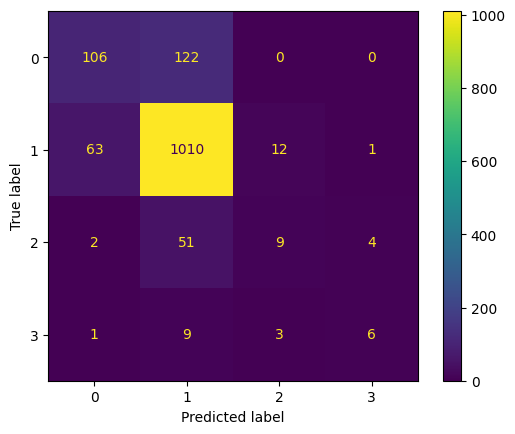

In [11]:
# Features (todas menos la columna objetivo)
X = df.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea entero)
y = df["estadoFitosanitario"].astype(int)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir modelo XGBoost para clasificación
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_clf.fit(X_train, y_train)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()


Para solventar el desbalanceo de clases que tienen los datos, primero vamos a optar por submuestreo de las clases mayoritarias, es este caso `Regular` y `Bueno`

Accuracy: 0.8120085775553967

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.56      0.58       228
           1       0.86      0.91      0.89      1086
           2       0.41      0.24      0.30        66
           3       0.80      0.21      0.33        19

    accuracy                           0.81      1399
   macro avg       0.67      0.48      0.53      1399
weighted avg       0.80      0.81      0.80      1399



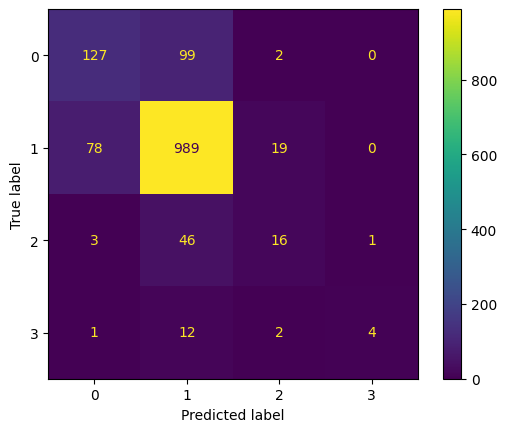

In [12]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)

# ---- Balancear SOLO el conjunto de entrenamiento ----
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

# ---- Definir y entrenar modelo ----
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

xgb_clf.fit(X_train_res, y_train_res)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()

Ahora analicemos un sobremuestreo de las clases minoritarias

Accuracy: 0.7676912080057183

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.46      0.54       228
           1       0.86      0.86      0.86      1086
           2       0.19      0.32      0.24        66
           3       0.26      0.47      0.33        19

    accuracy                           0.77      1399
   macro avg       0.49      0.53      0.49      1399
weighted avg       0.79      0.77      0.77      1399



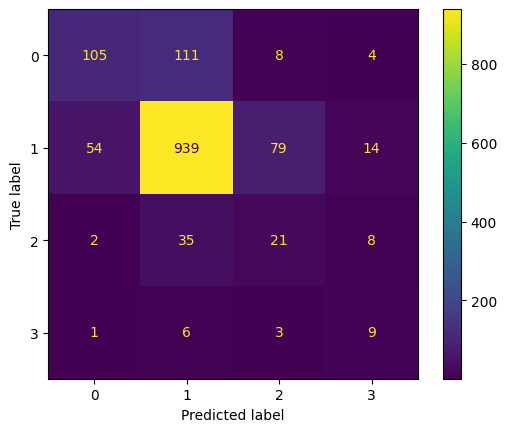

In [13]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()

### Random Foresft - Classifier
---

Accuracy: 0.7483917083631165

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.48      0.51       228
           1       0.86      0.84      0.85      1086
           2       0.20      0.33      0.25        66
           3       0.33      0.42      0.37        19

    accuracy                           0.75      1399
   macro avg       0.48      0.52      0.49      1399
weighted avg       0.77      0.75      0.76      1399



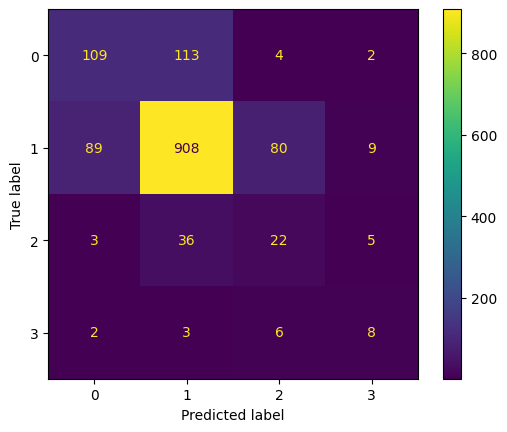

In [14]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

# Definir RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # esto equilibra automáticamente las clases
)

# 3Entrenar
rf_clf.fit(X_train_aug, y_train_aug)

# 4Predecir
y_pred = rf_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

### Decision Tree Classifier
---

Accuracy: 0.6904932094353109

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.52      0.48       228
           1       0.86      0.75      0.80      1086
           2       0.16      0.38      0.23        66
           3       0.16      0.21      0.18        19

    accuracy                           0.69      1399
   macro avg       0.41      0.47      0.42      1399
weighted avg       0.75      0.69      0.72      1399



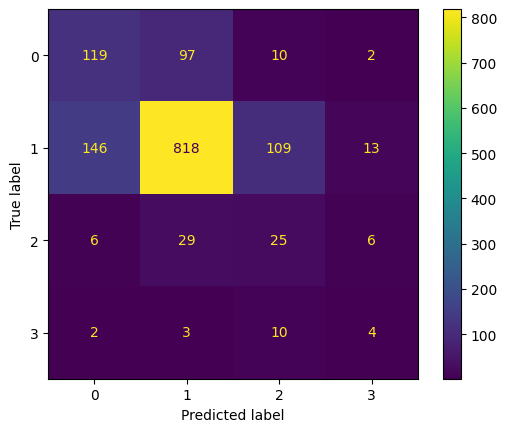

In [15]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  # rebalancea automáticamente las clases
    max_depth=None  # puedes ajustar para evitar overfitting
)

# Entrenar
dt_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

## Entrenamiento - 3 clases
----

### XGBoost - Classifier
---

In [16]:
df["estadoFitosanitario"] = df["estadoFitosanitario"].replace({2: 2, 3: 2})


Accuracy: 0.7719799857040743

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.46      0.53       228
           1       0.86      0.86      0.86      1086
           2       0.27      0.47      0.35        85

    accuracy                           0.77      1399
   macro avg       0.59      0.60      0.58      1399
weighted avg       0.79      0.77      0.78      1399



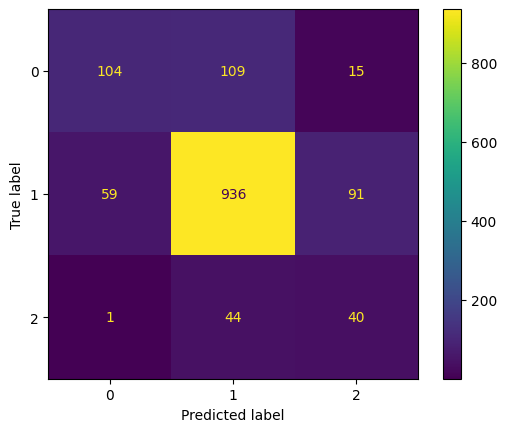

In [17]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]

X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2])
disp_pre.plot()

### Random Foresft - Classifier
---

Accuracy: 0.7541100786275912

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.49      0.52       228
           1       0.85      0.84      0.84      1086
           2       0.27      0.42      0.33        85

    accuracy                           0.75      1399
   macro avg       0.56      0.58      0.56      1399
weighted avg       0.77      0.75      0.76      1399



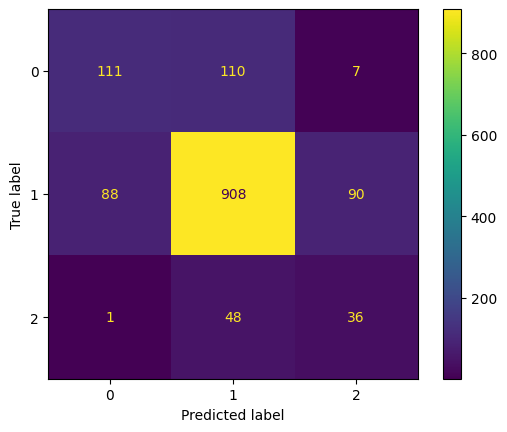

In [19]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)


# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

# Definir RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # esto equilibra automáticamente las clases
)

# 3Entrenar
rf_clf.fit(X_train_aug, y_train_aug)

# 4Predecir
y_pred = rf_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

### Decision Tree Classifier
---

Accuracy: 0.6940671908506075

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.55      0.50       228
           1       0.85      0.75      0.80      1086
           2       0.17      0.33      0.23        85

    accuracy                           0.69      1399
   macro avg       0.49      0.54      0.51      1399
weighted avg       0.74      0.69      0.71      1399



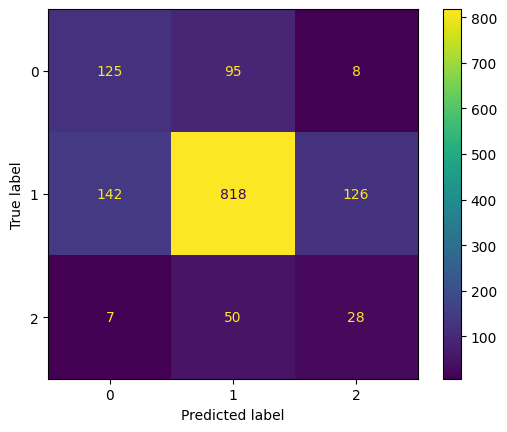

In [20]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]


# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  # rebalancea automáticamente las clases
    max_depth=None  # puedes ajustar para evitar overfitting
)

# Entrenar
dt_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()